## This notebook will help you train a latent Point-Cloud GAN.

(Assumes
latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import os
import os.path as osp
import sys
import matplotlib.pylab as plt

BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
sys.path.append(BASE) 

from src.point_net_ae import PointNetAutoEncoder
from src.autoencoder import Configuration as Conf
from src.neural_net import MODEL_SAVER_ID

from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from src.general_utils import plot_3d_point_cloud
from src.tf_utils import reset_tf_graph

from src.vanilla_gan import Vanilla_GAN
from src.w_gan_gp import W_GAN_GP
from src.generators_discriminators import latent_code_discriminator_two_layers,\
latent_code_generator_two_layers

Instructions for updating:
Colocations handled automatically by placer.
Success


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Specify where the raw point-clouds and the pre-trained AE are.

In [3]:
# Top-dir of where point-clouds are stored.
class_name = 'chair'
ae_loss = 'chamfer'  
top_in_dir = 'data/shape_net_core_uniform_samples_2048/'    

# ae_configuration = '../data/single_class_ae/configuration'
ae_configuration = 'single_class_ae_' + ae_loss
ae_configuration = osp.join(BASE, 'data', class_name, ae_configuration, 'configuration')
# ae_configuration = osp.join(BASE, 'data', class_name, 'single_class_ae/configuration')


In [4]:
# Where to save GANs check-points etc.
top_out_dir = 'data/'

top_out_dir = osp.join(BASE, top_out_dir, class_name)
top_in_dir = osp.join(BASE, top_in_dir)

experiment_name = 'latent_gan_with_chamfer_ae'
# experiment_name = osp.join(BASE, 'data', class_name, 'latent_gan_with_chamfer_ae')

ae_epoch = 500           # Epoch of AE to load.
bneck_size = 128         # Bottleneck-size of the AE
n_pc_points = 2048       # Number of points per model.

# class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

In [5]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
print ('Shape of DATA =', all_pc_data.point_clouds.shape)

6778 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (6778, 2048, 3)


In [6]:
# Load pre-trained AE
reset_tf_graph()
ae_conf = Conf.load(ae_configuration)
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
ae.restore_model(ae_conf.train_dir, ae_epoch, verbose=True)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-500
Model restored in epoch 500.


In [7]:
# Use AE to convert raw pointclouds to latent codes.
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)
latent_data = PointCloudDataSet(latent_codes)
print ('Shape of DATA =', latent_data.point_clouds.shape)

# def get_latent_codes(self, pclouds, batch_size=100):

Shape of DATA = (6778, 128)


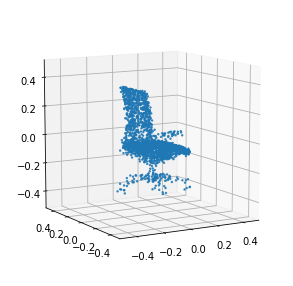

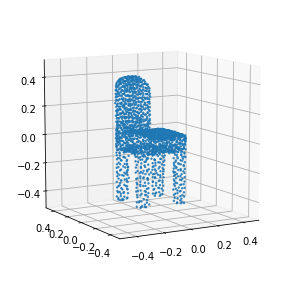

In [8]:
# Check the decoded AE latent-codes look descent.
L = ae.decode(latent_codes)
i = 0
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);
i = 20
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);

In [13]:
print(ae_conf.train_dir)

L.shape

/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer


(6778, 2048, 3)

In [12]:
import numpy as np
import pandas as pd
import os           
import tensorflow as tf

def createDir(dirname, path=os.getcwd()):
    dirpath = osp.join(path, dirname)
    try:
        os.mkdir(dirpath)
    except OSError as error:
        print ("exist")
        
# os.makedirs(osp.join(conf.train_dir, 'ae_npy'))
# os.makedirs(osp.join(conf.train_dir, 'ae_txt'))

createDir('ae_npy', ae_conf.train_dir)
# createDir('ae_txt', ae_conf.train_dir

np.savez(osp.join(ae_conf.train_dir, 'ae_npy', 'ae_reconstructions.npz'), L)
np.save(osp.join(ae_conf.train_dir, 'ae_npy', 'ae.npy'), L)
      

exist
